In [17]:
!pip install arviz
!pip install pyro-ppl
!pip install scikit-optimize
!pip install sklearn
!pip install dill
!pip install tensorflow
!pip install tensorflow-probability
!pip install funsor
# Requires R

     |████████████████████████████████| 4.8 MB 8.3 MB/s 
     |████████████████████████████████| 91 kB 8.6 MB/s 


In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from mvl import genData
from torch import tensor

liabParams55cov = genData.genParams(pis=tensor([.1, .1, .05]), rrMeans=tensor([5., 2.]), afMean = tensor(1e-4), pDs = tensor([.01, .01]), afShape=tensor(50.), nCases=tensor([1.5e4, 1.5e4, 4e3]), nCtrls=tensor(5e4), covShared=tensor([ [1, .95], [.95, 1] ]), meanEffectCovarianceScale=tensor(.01))[0]
liabParams55cov["pDs"] = liabParams55cov["pDs"][0:2]
liabData55cov = genData.v6liability(**liabParams55cov)
liabParams55cov["pDs"] = liabData55cov["PDs"] #TODO: normalized names, and indicate that the params pDs are incomplete

covShared tensor([[1.0000, 0.9500],
        [0.9500, 1.0000]])
residualCovariance tensor([[1, 0],
        [0, 1]])
PD1 threshold, PD2 threshold tensor(-2.3263) tensor(-2.3263)
pDsWithBoth tensor([0.0100, 0.0100, 0.0067], dtype=torch.float64)
pdThresh tensor([2.3263, 2.3263])
pdTarget tensor([0.0500, 0.0200])
pdvthresh tensor([1.6449, 2.0537])
meanEffect tensor([0.6815, 0.2726])
meanEffectsAcrossAllGenes tensor([0.6815, 0.2726])
allEffects tensor([[-0.7256, -0.3200],
        [-0.6518, -0.2669],
        [-0.6300, -0.2663],
        ...,
        [-0.5057, -0.1079],
        [-0.6912, -0.3320],
        [-0.4872, -0.0685]])
PD1GivenV.mean() tensor(0.0509) PD2GivenV.mean() tensor(0.0205)
allEffects[i] tensor([-0.7256, -0.3200])
PDBothGivenV.mean tensor(0.0195, dtype=torch.float64)
PDBothGivenV / PDBoth tensor(2.9035, dtype=torch.float64)
pdsCovarOnMean.mean(0) tensor([0.0509, 0.0205, 0.0195], dtype=torch.float64)
np.corrcoef(pdvInBoth[:,0], pdvInBoth[:,1])
 [[1.         0.94773982]
 [0.9477398

In [9]:
import numpyro
from numpyro.distributions import Multinomial, Beta, Dirichlet, DirichletMultinomial, Gamma, Beta, Categorical, Uniform, MultivariateNormal, Normal, LogNormal, Exponential, HalfCauchy, LKJCholesky
from jax import random
from numpyro.infer import MCMC, NUTS, SA, Predictive
import numpy as np
import jax.numpy as jnp
import jax

numpyro.set_host_device_count(6)
numpyro.enable_x64()


def get_pdhat(params):
    nCases = params["nCases"].numpy()
    nCtrls = params["nCtrls"].numpy()
    samplePDs = nCases / (nCases.sum() + nCtrls)
    pdsAll = np.array([1 - samplePDs.sum(), *samplePDs])
    return pdsAll

# mu_exp, var_exp = get_log_params(liabParams55cov["afMean"].numpy(), 1)
# Expected number of components
# For 2 case types it's
# none, 1only, 2only, both
# For 3 it's
# none, 1only, 2only, 3only, 1&2, 1&3, 2&3, 123 (7)
# for 4 it's
# none, 1only, 2only, 3only, 4only, 1&2, 1&3, 1&4, 2&3, 2&4, 3&4, 123, 124, 134, 234, 1234
# which is 4 + 4choose2 + nchoose3  + nchoose4 
def mix_weights(beta: jnp.array):
    beta_cumprod = (1 - beta).cumprod(-1)
    return jnp.pad(beta, (0,1), constant_values=1) * jnp.pad(beta_cumprod, (1,0), constant_values = 1)

# Covariates
# Sex of the individual
# parent of origin would be important
# 
def model(data, params, nHypotheses: int, alpha = .05):
    with numpyro.plate("beta_plate", nHypotheses-1):
        beta = numpyro.sample("beta", Beta(1, alpha / nHypotheses))

    with numpyro.plate("prob_plate", nHypotheses):
        pd_hat = get_pdhat(params)
        conc = numpyro.sample('conc', Exponential(pd_hat).to_event(1))
        probs = numpyro.sample("probs", Dirichlet(conc))

    with numpyro.plate("data", data.shape[0]):
        z = numpyro.sample("z", Categorical(mix_weights(beta)))
        return numpyro.sample("obs", Multinomial(probs=probs[z]), obs=data)

def model_mvn(data, params, nHypotheses: int, alpha = .05):
    kSampleCategories = data.shape[1]

    # If in pyro: conc = numpyro.sample('conc', Exponential(exponential_prior).to_event(1))
    with numpyro.plate("beta_plate", nHypotheses-1):
        beta = numpyro.sample("beta", Beta(1, alpha / nHypotheses))

    with numpyro.plate("prob_plate", nHypotheses):
        # sigma = numpyro.sample("sigma", dist.Exponential(np.ones(kConditions)).to_event(1))
        # Rho = numpyro.sample("Rho", dist.LKJ(kConditions, kConditions))
        # cov = jnp.outer(sigma, sigma) * Rho
        # print("cov", cov)
        # probs = jax.nn.softmax(numpyro.sample("probs", MultivariateNormal(0, np.eye(data.shape[1]))))
        # options = dict(dtype=y.dtype, device=y.device)
        # Vector of variances for each of the d variables
        theta = pyro.sample("theta", HalfCauchy(np.ones(kSampleCategories)))
        # Lower cholesky factor of a correlation matrix
        eta = np.ones(1)  # Implies a uniform distribution over correlation matrices
        L_omega = pyro.sample("L_omega", LKJCholesky(kSampleCategories, eta))
        # Lower cholesky factor of the covariance matrix
        L_Omega = jax.numpy.matmul(jax.numpy.diag(theta.sqrt()), L_omega)
        # For inference with SVI, one might prefer to use torch.bmm(theta.sqrt().diag_embed(), L_omega)

        # Vector of expectations
        mu = torch.zeros(kSampleCategories, **options)

    with numpyro.plate("data", data.shape[0]):
        z = numpyro.sample("z", Categorical(mix_weights(beta)))
        return numpyro.sample("obs", Multinomial(probs=probs[z]), obs=data)

def get_posterior_samples(mcmc):
    posterior_samples = mcmc.get_samples()
    posterior_samples['pi'] = stickbreak(posterior_samples['beta'])
    
    return posterior_samples

print("Ready")

Ready


In [10]:
mcmc = MCMC(NUTS(model, max_tree_depth=8), num_warmup=200, num_samples=1000)
mcmc.run(random.PRNGKey(12269), liabData55cov["altCounts"].numpy(), liabParams55cov, 12)
mcmc.print_summary()

ImportError: Looking like you want to do inference for models with discrete latent variables. This is an experimental feature. You need to install `funsor` to be able to use this feature. It can be installed with `pip install funsor`.

In [178]:
# #https://arviz-devs.github.io/arviz/getting_started/InferenceDataCookbook.html#cookbook
# from numpyro.infer import Predictive
# import arviz
posterior_samples = mcmc.get_samples()

# posterior_predictive = Predictive(model, posterior_samples_shallow)(random.PRNGKey(1), altCounts)
# prior = Predictive(model, num_samples=500)(random.PRNGKey(2), altCounts)

prob = posterior_samples["probs"]
print(prob.mean(0))

# rho_mvn = posterior_samples_mvn["sigma"]
# print(rho_mvn.mean(0))

beta = posterior_samples['beta']
weights = mix_weights(beta)
print("inferred stick-breaking weights mean: ", weights.mean(0))
print("inferred stick-breaking weights stdd: ", weights.std(0))



[[0.60590405 0.16781348 0.18059077 0.04569171]
 [0.28457082 0.43054761 0.21625968 0.06862189]
 [0.43585196 0.12120497 0.34881434 0.09412873]
 [0.33463855 0.44873481 0.10319232 0.11343432]
 [0.18738584 0.56157383 0.10294975 0.14809057]
 [0.06995432 0.20314701 0.19545285 0.53144581]
 [0.06937204 0.2019346  0.19193926 0.53675409]
 [0.06022908 0.20763642 0.18378427 0.54835023]
 [0.07502542 0.19639607 0.20484601 0.5237325 ]
 [0.06615532 0.20190475 0.21164262 0.52029731]
 [0.06738336 0.19981897 0.18470201 0.54809566]
 [0.06882853 0.19779339 0.19086395 0.54251412]]
inferred stick-breaking weights mean:  [0.71274772 0.06377521 0.07077262 0.13127539 0.02420297 0.00102073
 0.00099896 0.000999   0.000999   0.000999   0.00099847 0.000999  ]
inferred stick-breaking weights stdd:  [0.01710678 0.01439877 0.01656659 0.02658125 0.03379059 0.03159241
 0.03158814 0.03159117 0.03159119 0.03159118 0.03157441 0.03159119]


In [139]:
mcmc_mvn = MCMC(NUTS(model_mvn, max_tree_depth=8), num_warmup=200, num_samples=1000)
mcmc_mvn.run(random.PRNGKey(12269), liabData55cov["altCounts"].numpy(), liabParams55cov, 12)
mcmc_mvn.print_summary()

sample: 100%|██████████| 1200/1200 [32:32<00:00,  1.63s/it, 255 steps of size 1.11e-02. acc. prob=0.91]
                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.71      0.01      0.71      0.69      0.73    297.15      1.01
    beta[1]      0.22      0.04      0.22      0.14      0.29    423.17      1.00
    beta[2]      0.31      0.04      0.31      0.24      0.38    381.86      1.00
    beta[3]      0.55      0.30      0.65      0.14      0.93      3.04      2.76
    beta[4]      0.99      0.05      1.00      1.00      1.00    324.56      1.00
    beta[5]      0.97      0.12      1.00      0.98      1.00    884.59      1.00
    beta[6]      0.98      0.10      1.00      0.97      1.00   1073.62      1.00
    beta[7]      0.98      0.10      1.00      0.98      1.00    664.80      1.00
    beta[8]      0.97      0.12      1.00      0.98      1.00    936.84      1.00
    beta[9]      0.97      0.11      1.00      0.97      1.00    784.26     

In [140]:
# #https://arviz-devs.github.io/arviz/getting_started/InferenceDataCookbook.html#cookbook
# from numpyro.infer import Predictive
# import arviz
posterior_samples_mvn = mcmc_mvn.get_samples()

# posterior_predictive = Predictive(model, posterior_samples_shallow)(random.PRNGKey(1), altCounts)
# prior = Predictive(model, num_samples=500)(random.PRNGKey(2), altCounts)

prob_mvn = posterior_samples_mvn["probs"]
print(jax.nn.softmax(prob_mvn).mean(0))

# rho_mvn = posterior_samples_mvn["sigma"]
# print(rho_mvn.mean(0))

beta_mvn = posterior_samples_mvn['beta']
weights_mvn = mix_weights(beta_mvn)
print("inferred stick-breaking weights mean: ", weights_mvn.mean(0))
print("inferred stick-breaking weights stdd: ", weights_mvn.std(0))



[[0.60626807 0.16731796 0.18082107 0.0455929 ]
 [0.28410093 0.43076657 0.2165539  0.06857859]
 [0.43605601 0.12189203 0.3478063  0.09424566]
 [0.28209599 0.48887973 0.10284338 0.1261809 ]
 [0.27115838 0.49689642 0.1039052  0.12804   ]
 [0.24737777 0.24778018 0.25297688 0.25186517]
 [0.2567678  0.23597987 0.25921285 0.24803949]
 [0.23893117 0.26037389 0.25237292 0.24832203]
 [0.25064914 0.25386346 0.24950405 0.24598335]
 [0.26346573 0.24408289 0.23620134 0.25625004]
 [0.24922168 0.24763299 0.23820204 0.26494329]
 [0.25290151 0.25797329 0.24963679 0.23948842]]
inferred stick-breaking weights mean:  [0.7099922  0.06354308 0.0708965  0.08726734 0.07057747 0.00131235
 0.00099955 0.000999   0.0009988  0.000999   0.000999   0.000999  ]
inferred stick-breaking weights stdd:  [0.0168812  0.01495411 0.01449939 0.0503353  0.05554589 0.03170118
 0.03159117 0.03159119 0.03158481 0.03159119 0.03159119 0.03159119]


In [10]:
mcmc_mvn = MCMC(NUTS(model_mvn, max_tree_depth=8), num_warmup=100, num_samples=1000)
mcmc_mvn.run(random.PRNGKey(12269), liabData55cov["altCounts"].numpy(), liabParams55cov, 12)
mcmc_mvn.print_summary()

sample: 100%|██████████| 1100/1100 [30:53<00:00,  1.68s/it, 255 steps of size 1.44e-02. acc. prob=0.90]

                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.67      0.03      0.67      0.62      0.72    261.89      1.01
    beta[1]      0.42      0.18      0.43      0.15      0.70     67.83      1.03
    beta[2]      0.49      0.18      0.50      0.23      0.80     63.68      1.01
    beta[3]      0.87      0.23      1.00      0.51      1.00      8.41      1.20
    beta[4]      0.98      0.10      1.00      0.98      1.00    316.10      1.00
    beta[5]      0.98      0.11      1.00      0.98      1.00    360.50      1.00
    beta[6]      0.98      0.09      1.00      0.99      1.00    293.66      1.01
    beta[7]      0.97      0.11      1.00      0.98      1.00   1087.11      1.00
    beta[8]      0.97      0.11      1.00      0.97      1.00    111.75      1.01
    beta[9]      0.97      0.12      1.00      0.95      1.00    302.20    

In [11]:
# #https://arviz-devs.github.io/arviz/getting_started/InferenceDataCookbook.html#cookbook
# from numpyro.infer import Predictive
# import arviz
posterior_samples_mvn = mcmc_mvn.get_samples()

# posterior_predictive = Predictive(model, posterior_samples_shallow)(random.PRNGKey(1), altCounts)
# prior = Predictive(model, num_samples=500)(random.PRNGKey(2), altCounts)

prob_mvn = posterior_samples_mvn["probs"]
print(jax.nn.softmax(prob_mvn).mean(0))

# rho_mvn = posterior_samples_mvn["sigma"]
# print(rho_mvn.mean(0))

beta_mvn = posterior_samples_mvn['beta']
weights_mvn = mix_weights(beta_mvn)
print("inferred stick-breaking weights mean: ", weights_mvn.mean(0))
print("inferred stick-breaking weights stdd: ", weights_mvn.std(0))



[[0.61674879 0.16371156 0.17588072 0.04365893]
 [0.31449197 0.45521602 0.11754276 0.11274925]
 [0.33200139 0.38977244 0.18520407 0.0930221 ]
 [0.40428785 0.2092218  0.29835633 0.08813401]
 [0.28147425 0.2788624  0.24609171 0.19357164]
 [0.24906397 0.24302631 0.2562851  0.25162462]
 [0.25659984 0.24105186 0.25705822 0.24529008]
 [0.25021501 0.25553167 0.24936635 0.24488698]
 [0.24584122 0.25552193 0.24521343 0.25342342]
 [0.2608562  0.24612874 0.24244986 0.25056519]
 [0.25205916 0.24471351 0.24133316 0.26189418]
 [0.25172419 0.256544   0.25220737 0.23952444]]
inferred stick-breaking weights mean:  [0.66874843 0.13951459 0.09701564 0.08103281 0.01717479 0.00112159
 0.00098979 0.000999   0.00099058 0.000999   0.00099897 0.000999  ]
inferred stick-breaking weights stdd:  [0.03646482 0.05955085 0.05446124 0.04133595 0.04433081 0.03161073
 0.03058828 0.03159119 0.03132485 0.03159119 0.0315902  0.03159119]


In [155]:
# #https://arviz-devs.github.io/arviz/getting_started/InferenceDataCookbook.html#cookbook
# from numpyro.infer import Predictive
# import arviz
posterior_samples_mvn = mcmc_mvn.get_samples()

# posterior_predictive = Predictive(model, posterior_samples_shallow)(random.PRNGKey(1), altCounts)
# prior = Predictive(model, num_samples=500)(random.PRNGKey(2), altCounts)

prob_mvn = posterior_samples_mvn["probs"]
print(jax.nn.softmax(prob_mvn).mean(0))

# rho_mvn = posterior_samples_mvn["sigma"]
# print(rho_mvn.mean(0))

beta_mvn = posterior_samples_mvn['beta']
weights_mvn = mix_weights(beta_mvn)
print("inferred stick-breaking weights mean: ", weights_mvn.mean(0))
print("inferred stick-breaking weights stdd: ", weights_mvn.std(0))



[[0.60740289 0.17015959 0.17621194 0.04622558]
 [0.38267965 0.39211461 0.1288568  0.09634895]
 [0.41524403 0.19949909 0.30446832 0.08078857]
 [0.26083622 0.27882391 0.24400662 0.21633324]
 [0.26418463 0.23696862 0.25059069 0.24825606]
 [0.24470518 0.24254699 0.25674856 0.25599927]
 [0.25529044 0.23782388 0.25507793 0.25180775]
 [0.24269516 0.25489094 0.25557632 0.24683758]
 [0.2454478  0.25491142 0.25015448 0.2494863 ]
 [0.26499744 0.2388382  0.23905639 0.25710797]
 [0.24694513 0.24644214 0.23984802 0.26676472]
 [0.24488922 0.25154493 0.25940042 0.24416543]]
inferred stick-breaking weights mean:  [7.60776907e-01 1.09880132e-01 1.27151361e-01 5.40633036e-03
 1.02329829e-03 9.98913742e-04 2.70734446e-04 9.99000999e-04
 9.98717423e-04 9.99000997e-04 9.90438591e-04 9.99000999e-04]
inferred stick-breaking weights stdd:  [0.03732767 0.02564735 0.04806301 0.03537472 0.03159223 0.03158843
 0.00856137 0.03159119 0.03158222 0.03159119 0.03132042 0.03159119]


In [142]:
import numpyro.distributions as dist
key = random.PRNGKey(0)
key, *split = random.split(key, 4)

# with numpyro.handlers.seed(rng_seed=4):
# a = numpyro.sample("a", dist.Normal(5, 2), rng_key=split[1])
# b = numpyro.sample("b", dist.Normal(-1, 0.5), rng_key=split[2])
sigma_cafe = numpyro.sample("sigma_cafe", dist.Exponential(1).expand([2]), rng_key=key)
Rho = numpyro.sample("Rho", dist.LKJ(2, 2), rng_key=split[0])
cov = jnp.outer(sigma_cafe, sigma_cafe) * Rho
# print(cov)

print(cov)



[[0.14112049 0.06191058]
 [0.06191058 1.24910286]]


In [102]:
init_rng_key = random.PRNGKey(12272)
mcmc1shallow = MCMC(NUTS(model, max_tree_depth=6), 200, 1000)
mcmc1shallow.run(init_rng_key, data=liabData55cov["altCounts"].numpy(), params=liabParams55cov, nHypotheses=12, alpha=.05)
mcmc1shallow.print_summary()

  0%|          | 0/1200 [00:07<?, ?it/s]


KeyboardInterrupt: 

In [100]:
init_rng_key = random.PRNGKey(12272)
mcmc1shallow = MCMC(NUTS(model, max_tree_depth=6), 100, 1000)
mcmc1shallow.run(init_rng_key, data=liabData55cov["altCounts"].numpy(), params=liabParams55cov, nHypotheses=12, alpha=.05)
mcmc1shallow.print_summary()

sample: 100%|██████████| 1100/1100 [07:54<00:00,  2.32it/s, 31 steps of size 5.07e-02. acc. prob=0.54]

                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.71      0.02      0.71      0.69      0.73     55.77      1.02
    beta[1]      0.24      0.08      0.22      0.10      0.36     29.41      1.08
    beta[2]      0.07      0.08      0.05      0.00      0.18      9.96      1.43
    beta[3]      0.33      0.22      0.25      0.04      0.67      3.33      1.82
    beta[4]      0.57      0.27      0.44      0.31      1.00      3.17      1.81
    beta[5]      0.98      0.05      1.00      0.95      1.00     27.78      1.00
    beta[6]      0.95      0.13      1.00      0.86      1.00     25.08      1.17
    beta[7]      0.82      0.26      1.00      0.38      1.00      4.23      1.44
    beta[8]      0.83      0.22      0.95      0.52      1.00     15.17      1.01
    beta[9]      0.87      0.20      0.98      0.55      1.00     25.35     

In [101]:
#https://arviz-devs.github.io/arviz/getting_started/InferenceDataCookbook.html#cookbook
from numpyro.infer import Predictive
import arviz
posterior_samples_shallow = mcmc1shallow.get_samples()

# posterior_predictive = Predictive(model, posterior_samples_shallow)(random.PRNGKey(1), altCounts)
# prior = Predictive(model, num_samples=500)(random.PRNGKey(2), altCounts)

prob1shallow = posterior_samples_shallow["probs"]
print(prob1shallow.mean(0))

betaScaledShallow = mcmc1shallow.get_samples()['beta']
weightsShallow = mix_weights(betaScaledShallow)
print("inferred stick-breaking weights mean: ", weightsShallow.mean(0))
print("inferred stick-breaking weights stdd: ", weightsShallow.std(0))



[[0.60582873 0.16702445 0.18134851 0.0457983 ]
 [0.29811604 0.4293194  0.19770874 0.07485583]
 [0.26193127 0.39258634 0.17619536 0.16928703]
 [0.26007253 0.50357627 0.10533411 0.1310171 ]
 [0.4310408  0.12031992 0.35413292 0.09450636]
 [0.29028068 0.44269038 0.12914036 0.13788858]
 [0.08483023 0.30697448 0.39976867 0.20842662]
 [0.10067644 0.28437098 0.27640459 0.338548  ]
 [0.09747021 0.25084919 0.15051866 0.50116194]
 [0.06262883 0.23221926 0.19544839 0.50970353]
 [0.06268046 0.21187972 0.23968856 0.48575126]
 [0.05465889 0.20047113 0.18300672 0.56186326]]
inferred stick-breaking weights mean:  [0.71187852 0.06829629 0.01638261 0.06498401 0.06620591 0.07281238
 0.00092585 0.00181789 0.0009434  0.00092225 0.00099787 0.000999  ]
inferred stick-breaking weights stdd:  [0.01788072 0.0232247  0.01816736 0.0424705  0.01471036 0.05659828
 0.00655176 0.03196538 0.02975577 0.02915078 0.03155515 0.03159119]


In [19]:
init_rng_key = random.PRNGKey(12272)
mcmc1shallow = MCMC(NUTS(model, max_tree_depth=6), 100, 1000)
mcmc1shallow.run(init_rng_key, data=liabData55cov["altCounts"].numpy(), params=liabParams55cov, nHypotheses=12, alpha=.05)
mcmc1shallow.print_summary()

sample: 100%|██████████| 1100/1100 [07:54<00:00,  2.32it/s, 63 steps of size 2.63e-02. acc. prob=0.78]

                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.14      0.11      0.10      0.04      0.33      7.63      1.22
    beta[1]      0.72      0.05      0.73      0.63      0.76      8.35      1.17
    beta[2]      0.71      0.20      0.77      0.37      0.94     21.49      1.22
    beta[3]      0.96      0.09      1.00      0.89      1.00     14.74      1.05
    beta[4]      0.92      0.20      1.00      0.71      1.00     20.11      1.01
    beta[5]      0.91      0.26      1.00      0.65      1.00     23.23      1.02
    beta[6]      0.92      0.16      0.99      0.69      1.00      8.95      1.25
    beta[7]      0.76      0.34      0.97      0.11      1.00      4.24      1.55
    beta[8]      0.83      0.29      1.00      0.23      1.00      5.06      1.38
    beta[9]      0.87      0.22      0.99      0.54      1.00     27.36     

In [21]:
#https://arviz-devs.github.io/arviz/getting_started/InferenceDataCookbook.html#cookbook
from numpyro.infer import Predictive
import arviz
posterior_samples_shallow = mcmc1shallow.get_samples()

# posterior_predictive = Predictive(model, posterior_samples_shallow)(random.PRNGKey(1), altCounts)
# prior = Predictive(model, num_samples=500)(random.PRNGKey(2), altCounts)

prob1shallow = posterior_samples_shallow["probs"]
print(prob1shallow.mean(0))

betaScaledShallow = mcmc1shallow.get_samples()['beta']
weightsShallow = mix_weights(betaScaledShallow)
print("inferred stick-breaking weights mean: ", weightsShallow.mean(0))
print("inferred stick-breaking weights stdd: ", weightsShallow.std(0))



[[0.45312828 0.14597836 0.32229318 0.07860018]
 [0.62233275 0.16419076 0.17088956 0.04258692]
 [0.29239886 0.45312807 0.15511535 0.09935772]
 [0.38519813 0.43645675 0.05195166 0.12639345]
 [0.08550515 0.43753994 0.31796844 0.15898647]
 [0.08196345 0.15096541 0.2315737  0.53549744]
 [0.03403948 0.19540557 0.31003209 0.46052287]
 [0.06417592 0.34796739 0.2335989  0.35425779]
 [0.11637405 0.21550084 0.13887621 0.52924891]
 [0.09574987 0.1779026  0.21532947 0.51101806]
 [0.09329781 0.19049132 0.18525536 0.53095552]
 [0.08248922 0.18779305 0.20796643 0.52175131]]
inferred stick-breaking weights mean:  [1.39132146e-01 6.22863608e-01 1.70748077e-01 6.73360470e-02
 2.14173222e-03 2.72638336e-05 1.21283833e-03 1.03657846e-03
 7.59609385e-04 8.28155345e-04 9.83570130e-04 9.99002605e-04]
inferred stick-breaking weights stdd:  [0.1107305  0.10923567 0.04922772 0.05368682 0.01442141 0.00046444
 0.02845797 0.0292043  0.02390029 0.02617198 0.03110127 0.03159119]


In [56]:
# With 2x the number of components
# Speed appears to halve, but still > 2it/s, still takes only 63 steps per it
# actual result: 8:14s vs 04:46s for 6 components
mcmc1_shallow_12 = MCMC(NUTS(model, max_tree_depth=6,), 100, 1000)
mcmc1_shallow_12.run(random.PRNGKey(12275), liabData55cov["altCounts"].numpy(), liabParams55cov, 12)
mcmc1_shallow_12.print_summary()

sample:  21%|██▏       | 234/1100 [01:48<06:42,  2.15it/s, 63 steps of size 1.21e-01. acc. prob=0.15]


KeyboardInterrupt: 

In [104]:
#https://arviz-devs.github.io/arviz/getting_started/InferenceDataCookbook.html#cookbook
from numpyro.infer import Predictive
import arviz
posterior_samples_shallow_12 = mcmc1_shallow_12.get_samples()

# posterior_predictive_shallow_12 = Predictive(model, posterior_samples_shallow_12)(random.PRNGKey(1), altCounts)
# prior_shallow_12 = Predictive(model, num_samples=500,)(random.PRNGKey(2), altCounts)

prob_shallow_12 = posterior_samples_shallow_12["probs"]
print(prob_shallow_12.mean(0))

beta_shallow_12 = posterior_samples_shallow_12['beta']
weights_shallow_12 = mix_weights(beta_shallow_12)
print("inferred stick-breaking weights mean: ", weights_shallow_12.mean(0))
print("inferred stick-breaking weights stdd: ", weights_shallow_12.std(0))

[[0.38105108 0.3965674  0.12489255 0.09748898]
 [0.60709553 0.17033781 0.1763172  0.04624947]
 [0.41337435 0.20288563 0.30328678 0.08045323]
 [0.06615038 0.13269253 0.17183879 0.62931831]
 [0.07569807 0.27921603 0.19767125 0.44741465]
 [0.04257301 0.21798584 0.26984293 0.46959822]
 [0.09619933 0.21409614 0.23392239 0.45578214]
 [0.06020671 0.14967303 0.20698751 0.58313275]
 [0.06658376 0.20102428 0.23821231 0.49417965]
 [0.06939937 0.26573366 0.20338621 0.46148076]
 [0.04581577 0.21744692 0.2080805  0.52865682]
 [0.06406772 0.24372867 0.21472869 0.47747492]]
inferred stick-breaking weights mean:  [1.08861562e-01 7.63087980e-01 1.30083346e-01 1.00370742e-03
 9.35677342e-04 9.29108002e-04 5.61084287e-04 5.89527824e-04
 9.76334008e-04 9.79402634e-04 9.35222041e-04 9.99000999e-04]
inferred stick-breaking weights stdd:  [0.03153254 0.0363545  0.04467069 0.03157144 0.02958298 0.02938097
 0.01774304 0.01864251 0.03087439 0.03097143 0.02957432 0.03159119]


In [23]:
# With tree depth 7, roughly 2x as fast a 8?
init_rng_key = random.PRNGKey(12277)
mcmc1_shallow_12_7 = MCMC(NUTS(model, max_tree_depth=7), 100, 1000)
mcmc1_shallow_12_7.run(init_rng_key, data=liabData55cov["altCounts"].numpy(), params=liabParams55cov, nHypotheses=12, alpha=.s05)
mcmc1_shallow_12_7.print_summary()

sample: 100%|██████████| 1100/1100 [15:24<00:00,  1.19it/s, 127 steps of size 3.19e-02. acc. prob=0.89]

                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.13      0.05      0.14      0.04      0.21    203.88      1.00
    beta[1]      0.78      0.06      0.78      0.69      0.88    289.35      1.00
    beta[2]      0.53      0.17      0.55      0.27      0.80    171.73      1.00
    beta[3]      0.99      0.07      1.00      1.00      1.00     28.59      1.03
    beta[4]      0.97      0.12      1.00      0.96      1.00    216.80      1.01
    beta[5]      0.98      0.08      1.00      0.99      1.00    124.72      1.00
    beta[6]      0.97      0.14      1.00      0.97      1.00    364.62      1.00
    beta[7]      0.96      0.13      1.00      0.95      1.00    240.25      1.00
    beta[8]      0.98      0.11      1.00      1.00      1.00    338.93      1.00
    beta[9]      0.98      0.10      1.00      0.97      1.00    840.55    

In [24]:
#https://arviz-devs.github.io/arviz/getting_started/InferenceDataCookbook.html#cookbook
from numpyro.infer import Predictive
import arviz
posterior_samples_shallow_12_7 = mcmc1_shallow_12_7.get_samples()

# posterior_predictive_shallow_12_7 = Predictive(model, posterior_samples_shallow_12_7)(random.PRNGKey(1), altCounts)
# prior_shallow_12_7 = Predictive(model, num_samples=500)(random.PRNGKey(2), altCounts)

prob_shallow_12_7 = posterior_samples_shallow_12_7["probs"]
print(prob_shallow_12_7.mean(0))

beta_shallow_12_7 = posterior_samples_shallow_12_7['beta']
weights_shallow_12_7 = mix_weights(beta_shallow_12_7)
print("inferred stick-breaking weights mean: ", weights_shallow_12_7.mean(0))
print("inferred stick-breaking weights stdd: ", weights_shallow_12_7.std(0))

[[0.29446232 0.43746818 0.17880681 0.08926269]
 [0.61515106 0.16463266 0.17635425 0.04386202]
 [0.34458739 0.45356143 0.07905071 0.12280047]
 [0.43194439 0.13456096 0.347025   0.08646964]
 [0.1090604  0.22571011 0.25355814 0.41167135]
 [0.0754253  0.19415615 0.2033987  0.52701985]
 [0.06961144 0.19224309 0.21289402 0.52525145]
 [0.07282544 0.19800334 0.20283271 0.52633851]
 [0.07464896 0.188949   0.19753047 0.53887157]
 [0.06545556 0.22790075 0.18720745 0.51943624]
 [0.06327828 0.20554535 0.18949784 0.54167853]
 [0.08163256 0.19331243 0.18280938 0.54224563]]
inferred stick-breaking weights mean:  [1.33222511e-01 6.78963829e-01 1.07031822e-01 8.19112590e-02
 2.58904224e-03 6.26898850e-04 9.96649747e-04 9.98656631e-04
 9.99000751e-04 9.99000999e-04 9.99000999e-04 9.99000999e-04]
inferred stick-breaking weights stdd:  [0.06062843 0.05137643 0.05735569 0.03391717 0.03271605 0.01976191
 0.03151656 0.0315803  0.03159118 0.03159119 0.03159119 0.03159119]


In [67]:
#https://arviz-devs.github.io/arviz/getting_started/InferenceDataCookbook.html#cookbook
from numpyro.infer import Predictive
import arviz
posterior_samples_shallow_12_7 = mcmc1_shallow_12_7.get_samples()

# posterior_predictive_shallow_12_7 = Predictive(model, posterior_samples_shallow_12_7)(random.PRNGKey(1), altCounts)
# prior_shallow_12_7 = Predictive(model, num_samples=500)(random.PRNGKey(2), altCounts)

prob_shallow_12_7 = posterior_samples_shallow_12_7["probs"]
print(prob_shallow_12_7.mean(0))

beta_shallow_12_7 = posterior_samples_shallow_12_7['beta']
weights_shallow_12_7 = mix_weights(beta_shallow_12_7)
print("inferred stick-breaking weights mean: ", weights_shallow_12_7.mean(0))
print("inferred stick-breaking weights stdd: ", weights_shallow_12_7.std(0))

[[0.1561927  0.07849469 0.57388479 0.19142782]
 [0.2811232  0.4472441  0.1648169  0.10681579]
 [0.06149495 0.2137778  0.59902273 0.12570453]
 [0.12853358 0.27688683 0.31923523 0.27534435]
 [0.21870363 0.34333463 0.29944251 0.13851923]
 [0.51846513 0.03431081 0.08116547 0.3660586 ]
 [0.22681807 0.09604047 0.53162987 0.14551159]
 [0.27736817 0.26879645 0.36243599 0.09139939]
 [0.40635345 0.10416017 0.35180424 0.13768214]
 [0.10317901 0.12356018 0.21502565 0.55823516]
 [0.85588418 0.07974335 0.03521861 0.02915387]
 [0.93020128 0.03131587 0.02938837 0.00909448]]
inferred stick-breaking weights mean:  [2.25016907e-01 4.14029823e-01 2.62139329e-01 8.14439951e-02
 1.47822271e-02 4.92459583e-03 2.28056793e-03 2.19668613e-04
 1.84096316e-04 9.30608135e-04 4.63008433e-04 1.01494653e-03]
inferred stick-breaking weights stdd:  [0.02450712 0.01204865 0.014897   0.02280088 0.02188849 0.02261856
 0.02731553 0.00569141 0.00492958 0.02554814 0.01422771 0.03159068]


In [85]:
#https://arviz-devs.github.io/arviz/getting_started/InferenceDataCookbook.html#cookbook
from numpyro.infer import Predictive
import arviz
posterior_samples_shallow_12_7 = mcmc1_shallow_12_7.get_samples()

posterior_predictive_shallow_12_7 = Predictive(model, posterior_samples_shallow_12_7)(random.PRNGKey(1), altCounts)
prior_shallow_12_7 = Predictive(model, num_samples=500)(random.PRNGKey(2), altCounts)

prob_shallow_12_7 = posterior_samples_shallow_12_7["probs"]
print(prob_shallow_12_7.mean(0))

beta_shallow_12_7 = posterior_samples_shallow_12_7['beta']
weights_shallow_12_7 = mix_weights(beta_shallow_12_7)
print("inferred stick-breaking weights mean: ", weights_shallow_12_7.mean(0))
print("inferred stick-breaking weights stdd: ", weights_shallow_12_7.std(0))

[[0.33173251 0.37678289 0.21114732 0.08033728]
 [0.47742279 0.14035764 0.29699542 0.08522415]
 [0.42176567 0.35977962 0.10612409 0.11233062]
 [0.60816102 0.17680399 0.17383013 0.04120486]
 [0.09221491 0.20257156 0.22548958 0.47972395]
 [0.07405939 0.19828925 0.1978399  0.52981147]
 [0.06524019 0.17453206 0.22806434 0.5321634 ]
 [0.09129762 0.15168894 0.21483506 0.54217838]
 [0.08602935 0.20386537 0.20439718 0.50570809]
 [0.05288289 0.23137158 0.1809478  0.53479773]
 [0.05803799 0.23189296 0.16591872 0.54415032]
 [0.09232233 0.20202711 0.18248785 0.5231627 ]]
inferred stick-breaking weights mean:  [0.09134486 0.14961421 0.11245278 0.64933292 0.00093485 0.00092969
 0.00095582 0.00099876 0.000999   0.00099735 0.000999   0.000999  ]
inferred stick-breaking weights stdd:  [0.03892508 0.04462906 0.03394091 0.03902477 0.02912067 0.02933935
 0.03022508 0.03158367 0.03159118 0.03153906 0.03159119 0.03159119]


In [80]:
#https://arviz-devs.github.io/arviz/getting_started/InferenceDataCookbook.html#cookbook
from numpyro.infer import Predictive
import arviz
posterior_samples_shallow_12_7 = mcmc1_shallow_12_7.get_samples()

posterior_predictive_shallow_12_7 = Predictive(model, posterior_samples_shallow_12_7)(random.PRNGKey(1), altCounts)
prior_shallow_12_7 = Predictive(model, num_samples=500)(random.PRNGKey(2), altCounts)

prob_shallow_12_7 = posterior_samples_shallow_12_7["probs"]
print(prob_shallow_12_7.mean(0))

beta_shallow_12_7 = posterior_samples_shallow_12_7['beta']
weights_shallow_12_7 = mix_weights(beta_shallow_12_7)
print("inferred stick-breaking weights mean: ", weights_shallow_12_7.mean(0))
print("inferred stick-breaking weights stdd: ", weights_shallow_12_7.std(0))

[[0.47812082 0.14007595 0.29641373 0.08538949]
 [0.33743373 0.37546813 0.20495509 0.08214305]
 [0.60787163 0.17700772 0.17392798 0.04119267]
 [0.42847248 0.35769411 0.09960923 0.11422418]
 [0.63533005 0.19351306 0.09153351 0.07962338]
 [0.52022331 0.2074242  0.2094564  0.06289608]
 [0.46145399 0.23988845 0.23891069 0.05974688]
 [0.55500881 0.14233603 0.27982428 0.02283089]
 [0.60969118 0.16947231 0.13347808 0.08735842]
 [0.30097555 0.51377649 0.07802635 0.10722161]
 [0.46955517 0.39332311 0.06483065 0.07229106]
 [0.6503142  0.20830758 0.07996386 0.06141436]]
inferred stick-breaking weights mean:  [0.1499326  0.1031971  0.64912474 0.10061613 0.00126433 0.00091556
 0.00099707 0.00095441 0.00099899 0.00099897 0.000999   0.000999  ]
inferred stick-breaking weights stdd:  [0.04574475 0.03706621 0.04469692 0.04074861 0.03123071 0.02765979
 0.03151594 0.03018101 0.03159096 0.0315902  0.03159118 0.03159119]


In [ ]:
# With .05 / nHypothesis prior
# With 2x the number of components and max_tree_depth 8 instead of 6.  1/4 as fast during warmup, but still may be acceptable
# DUring inference, it gets up to 1-2it/s, so up to 1/2 as fast. 127 steps, but sometimes 63

# Speed appears to halve, but still > 2it/s, still takes only 63 steps per it
# actual result: 12:30s vs 8:14s with tree depth 8
nHypotheses = 12
init_rng_key = random.PRNGKey(12276)
mcmc1_shallow_12 = MCMC(NUTS(model, max_tree_depth=7), 100, 1000)
mcmc1_shallow_12.run(init_rng_key, altCounts)
mcmc1_shallow_12.print_summary()

In [74]:
# With .05 / nHypothesis prior
# With 2x the number of components and max_tree_depth 8 instead of 6.  1/4 as fast during warmup, but still may be acceptable
# DUring inference, it gets up to 1-2it/s, so up to 1/2 as fast. 127 steps, but sometimes 63

# Speed appears to halve, but still > 2it/s, still takes only 63 steps per it
# actual result: 12:30s vs 8:14s with tree depth 8
nHypotheses = 12
alpha = .01/2
init_rng_key = random.PRNGKey(12276)
mcmc1_shallow_12 = MCMC(NUTS(model, max_tree_depth=8), 100, 1000)
mcmc1_shallow_12.run(init_rng_key, altCounts)
mcmc1_shallow_12.print_summary()

sample: 100%|██████████| 1100/1100 [29:51<00:00,  1.63s/it, 255 steps of size 6.20e-02. acc. prob=0.90]

                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.65      0.04      0.65      0.59      0.71    969.29      1.00
    beta[1]      0.42      0.06      0.42      0.31      0.51   1007.30      1.00
    beta[2]      0.58      0.13      0.59      0.36      0.79    860.24      1.00
    beta[3]      1.00      0.01      1.00      1.00      1.00    922.16      1.00
    beta[4]      0.97      0.11      1.00      0.96      1.00    983.82      1.00
    beta[5]      0.97      0.11      1.00      0.98      1.00   1053.54      1.00
    beta[6]      0.97      0.12      1.00      0.98      1.00    997.38      1.00
    beta[7]      0.97      0.13      1.00      0.97      1.00    916.78      1.00
    beta[8]      0.97      0.11      1.00      0.97      1.00    957.99      1.00
    beta[9]      0.98      0.09      1.00      0.98      1.00   1103.10    

In [75]:
#https://arviz-devs.github.io/arviz/getting_started/InferenceDataCookbook.html#cookbook
from numpyro.infer import Predictive
import arviz
posterior_samples_shallow_12_82 = mcmc1_shallow_12.get_samples()

posterior_predictive_shallow_12_82 = Predictive(model, posterior_samples_shallow_12_82)(random.PRNGKey(3), altCounts)
prior_shallow_12_82 = Predictive(model, num_samples=500)(random.PRNGKey(4), altCounts)

prob_shallow_12_82 = posterior_samples_shallow_12_82["probs"]
print(prob_shallow_12_82.mean(0))

beta_shallow_12_82 = posterior_samples_shallow_12_82['beta']
weights_shallow_12_82 = mix_weights(beta_shallow_12_82)
print("inferred stick-breaking weights mean: ", weights_shallow_12_82.mean(0))
print("inferred stick-breaking weights stdd: ", weights_shallow_12_82.std(0))


[[0.60779161 0.17695785 0.17398098 0.04126957]
 [0.47750379 0.13982881 0.29697568 0.08569172]
 [0.41972903 0.36059798 0.10820411 0.11146889]
 [0.32928953 0.37686015 0.21475458 0.07909574]
 [0.52268963 0.21860311 0.17717223 0.08153503]
 [0.5043688  0.19000033 0.22039062 0.08524025]
 [0.49696973 0.21380118 0.18990064 0.09932845]
 [0.53080489 0.19249831 0.19332191 0.08337489]
 [0.50705313 0.18690241 0.21933174 0.08671272]
 [0.58024046 0.14063027 0.18910173 0.09002753]
 [0.50351272 0.18639899 0.20779018 0.10229811]
 [0.51046051 0.19051043 0.19983452 0.09919455]]
inferred stick-breaking weights mean:  [0.65087375 0.14619406 0.11726908 0.08585446 0.00111522 0.00100087
 0.000999   0.000999   0.00099893 0.00089702 0.000999   0.000999  ]
inferred stick-breaking weights stdd:  [0.03883303 0.03012401 0.03366777 0.03950153 0.03159289 0.03159115
 0.03159119 0.03159119 0.03158901 0.02836618 0.03159117 0.03159119]


In [56]:
# With 2x the number of components and max_tree_depth 8 instead of 6.  1/4 as fast during warmup, but still may be acceptable
# DUring inference, it gets up to 1-2it/s, so up to 1/2 as fast. 127 steps, but sometimes 63

# Speed appears to halve, but still > 2it/s, still takes only 63 steps per it
# actual result: 12:30s vs 8:14s with tree depth 8
nHypotheses = 12
init_rng_key = random.PRNGKey(12276)
mcmc1_shallow_12 = MCMC(NUTS(model, max_tree_depth=8), 100, 1000)
mcmc1_shallow_12.run(init_rng_key, altCounts)
mcmc1_shallow_12.print_summary()

sample: 100%|██████████| 1100/1100 [12:30<00:00,  1.47it/s, 63 steps of size 1.21e-01. acc. prob=0.83]

                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.11      0.03      0.11      0.06      0.15   1011.14      1.00
    beta[1]      0.73      0.05      0.73      0.66      0.80   1571.55      1.00
    beta[2]      0.59      0.09      0.59      0.43      0.73    960.29      1.00
    beta[3]      1.00      0.01      1.00      1.00      1.00    508.80      1.00
    beta[4]      0.97      0.13      1.00      0.96      1.00    806.85      1.00
    beta[5]      0.97      0.11      1.00      0.98      1.00    894.43      1.00
    beta[6]      0.97      0.11      1.00      0.96      1.00    634.29      1.01
    beta[7]      0.98      0.11      1.00      0.98      1.00    821.44      1.00
    beta[8]      0.97      0.12      1.00      0.96      1.00   1112.06      1.00
    beta[9]      0.97      0.11      1.00      0.97      1.00    971.72     

In [60]:
#https://arviz-devs.github.io/arviz/getting_started/InferenceDataCookbook.html#cookbook
from numpyro.infer import Predictive
import arviz
posterior_samples_shallow_12_8 = mcmc1_shallow_12.get_samples()

posterior_predictive_shallow_12_8 = Predictive(model, posterior_samples_shallow_12_8)(random.PRNGKey(3), altCounts)
prior_shallow_12_8 = Predictive(model, num_samples=500)(random.PRNGKey(4), altCounts)

prob_shallow_12_8 = posterior_samples_shallow_12_8["probs"]
print(prob_shallow_12_8.mean(0))

beta_shallow_12_8 = posterior_samples_shallow_12_8['beta']
weights_shallow_12_8 = mix_weights(beta_shallow_12_8)
print("inferred stick-breaking weights mean: ", weights_shallow_12_8.mean(0))
print("inferred stick-breaking weights stdd: ", weights_shallow_12_8.std(0))


[[0.33837388 0.37515634 0.20368977 0.08278002]
 [0.60762657 0.17673843 0.17420694 0.04142806]
 [0.47559996 0.13940189 0.29901631 0.08598184]
 [0.42921905 0.35778335 0.09877124 0.11422636]
 [0.25127128 0.24542413 0.25702803 0.24627656]
 [0.24705352 0.25525046 0.25622663 0.24146939]
 [0.25370517 0.26227912 0.22330641 0.2607093 ]
 [0.25697685 0.24311631 0.25830912 0.24159772]
 [0.2391295  0.26437516 0.23770062 0.25879471]
 [0.2451957  0.26166862 0.242633   0.25050268]
 [0.23767351 0.26156451 0.2527936  0.24796837]
 [0.25492683 0.26556019 0.2260203  0.25349268]]
inferred stick-breaking weights mean:  [0.10602952 0.65449745 0.14368539 0.0987603  0.00116081 0.00100162
 0.000999   0.000999   0.000999   0.000999   0.00099877 0.000999  ]
inferred stick-breaking weights stdd:  [0.04005045 0.04798781 0.03658517 0.04039464 0.03160592 0.03159113
 0.03159107 0.03159119 0.03159119 0.03159119 0.03158394 0.03159119]


In [83]:
# With tree depth 7, roughly 2x as fast a 8?
init_rng_key = random.PRNGKey(12277)
mcmc1_shallow_12_8 = MCMC(NUTS(model, max_tree_depth=8), 100, 1000)
mcmc1_shallow_12_8.run(init_rng_key, data=liabData55cov["altCounts"].numpy(), params=liabParams55cov, nHypotheses=12, alpha=.05)
mcmc1_shallow_12_8.print_summary()

sample: 100%|██████████| 1100/1100 [29:17<00:00,  1.60s/it, 255 steps of size 1.89e-02. acc. prob=0.91]

                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.18      0.05      0.19      0.09      0.23    270.14      1.00
    beta[1]      0.81      0.07      0.82      0.70      0.90    383.74      1.00
    beta[2]      0.63      0.19      0.65      0.34      0.93    291.40      1.00
    beta[3]      0.98      0.10      1.00      1.00      1.00     70.08      1.00
    beta[4]      0.97      0.11      1.00      0.98      1.00    489.84      1.00
    beta[5]      0.98      0.11      1.00      0.99      1.00    451.27      1.00
    beta[6]      0.98      0.11      1.00      1.00      1.00    750.32      1.00
    beta[7]      0.97      0.13      1.00      0.97      1.00    922.77      1.00
    beta[8]      0.98      0.10      1.00      0.99      1.00    630.12      1.00
    beta[9]      0.98      0.11      1.00      0.98      1.00   1092.69    

In [86]:
#https://arviz-devs.github.io/arviz/getting_started/InferenceDataCookbook.html#cookbook
from numpyro.infer import Predictive
import arviz
posterior_samples_shallow_12_8 = mcmc1_shallow_12_8.get_samples()

# posterior_predictive_shallow_12_8 = Predictive(model, posterior_samples_shallow_12_8)(random.PRNGKey(3), altCounts)
# prior_shallow_12_8 = Predictive(model, num_samples=500)(random.PRNGKey(4), altCounts)

prob_shallow_12_8 = posterior_samples_shallow_12_8["probs"]
print(prob_shallow_12_8.mean(0))

beta_shallow_12_8 = posterior_samples_shallow_12_8['beta']
weights_shallow_12_8 = mix_weights(beta_shallow_12_8)
print("inferred stick-breaking weights mean: ", weights_shallow_12_8.mean(0))
print("inferred stick-breaking weights stdd: ", weights_shallow_12_8.std(0))


[[0.30377644 0.45311113 0.13795726 0.10515517]
 [0.61712929 0.16500026 0.17435261 0.04351785]
 [0.44132347 0.13930102 0.33661717 0.08275834]
 [0.3429437  0.43648684 0.11309451 0.10747495]
 [0.07523031 0.20594294 0.20511673 0.51371002]
 [0.08227192 0.16354512 0.20155697 0.55262599]
 [0.06730327 0.21746003 0.2052907  0.50994599]
 [0.07272663 0.209903   0.19411984 0.52325053]
 [0.06934354 0.19682432 0.18573111 0.54810103]
 [0.07794825 0.21272921 0.19806921 0.51125332]
 [0.07145856 0.20091956 0.19880063 0.52882125]
 [0.07448439 0.19915904 0.20187055 0.52448601]]
inferred stick-breaking weights mean:  [0.1760342  0.66463708 0.09898307 0.06300054 0.00300039 0.00099942
 0.000999   0.000999   0.000999   0.00099021 0.00099898 0.000999  ]
inferred stick-breaking weights stdd:  [0.05533186 0.05418316 0.04611164 0.05688793 0.03439162 0.03159117
 0.03159118 0.03159118 0.03159119 0.03131309 0.03159062 0.03159119]


In [87]:
mcmc1_shallow_12_10 = MCMC(NUTS(model, max_tree_depth=10), 100, 1000)
mcmc1_shallow_12_10.run(random.PRNGKey(12277), data=liabData55cov["altCounts"].numpy(), params=liabParams55cov, nHypotheses=12, alpha=.05)
mcmc1_shallow_12_10.print_summary()

sample: 100%|██████████| 1100/1100 [1:07:41<00:00,  3.69s/it, 511 steps of size 1.07e-02. acc. prob=0.93]

                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.16      0.06      0.18      0.07      0.24    244.00      1.00
    beta[1]      0.13      0.06      0.12      0.05      0.21    909.69      1.00
    beta[2]      0.90      0.07      0.92      0.79      1.00    242.76      1.00
    beta[3]      0.98      0.10      1.00      0.99      1.00    128.04      1.00
    beta[4]      0.97      0.12      1.00      0.95      1.00    911.06      1.00
    beta[5]      0.97      0.12      1.00      0.97      1.00    990.98      1.00
    beta[6]      0.98      0.10      1.00      0.97      1.00   1047.38      1.00
    beta[7]      0.97      0.13      1.00      0.97      1.00    893.30      1.00
    beta[8]      0.97      0.12      1.00      0.98      1.00   1078.27      1.00
    beta[9]      0.97      0.13      1.00      0.96      1.00    887.12  

In [89]:
#https://arviz-devs.github.io/arviz/getting_started/InferenceDataCookbook.html#cookbook
from numpyro.infer import Predictive
import arviz
posterior_samples_shallow_12_10 = mcmc1_shallow_12_10.get_samples()

# posterior_predictive_shallow_12_8 = Predictive(model, posterior_samples_shallow_12_8)(random.PRNGKey(3), altCounts)
# prior_shallow_12_8 = Predictive(model, num_samples=500)(random.PRNGKey(4), altCounts)

prob_shallow_12_10 = posterior_samples_shallow_12_10["probs"]
print(prob_shallow_12_10.mean(0))

beta_shallow_12_10 = posterior_samples_shallow_12_10['beta']
weights_shallow_12_10 = mix_weights(beta_shallow_12_10)
print("inferred stick-breaking weights mean: ", weights_shallow_12_10.mean(0))
print("inferred stick-breaking weights stdd: ", weights_shallow_12_10.std(0))


[[0.30738537 0.44783538 0.14268885 0.1020904 ]
 [0.44864483 0.13993207 0.33035055 0.08107254]
 [0.61919151 0.16473923 0.1729044  0.04316486]
 [0.32756527 0.44368142 0.11937678 0.10937652]
 [0.07276696 0.23647248 0.20461265 0.48614791]
 [0.06909424 0.19760561 0.19543318 0.53786698]
 [0.06994242 0.2019215  0.19640975 0.53172633]
 [0.07758577 0.19692069 0.20010271 0.52539083]
 [0.06766889 0.19443054 0.20640863 0.53149194]
 [0.05905901 0.20406456 0.19668426 0.54019217]
 [0.07377089 0.19961523 0.20094603 0.52566785]
 [0.07005031 0.19943905 0.18586788 0.54464276]]
inferred stick-breaking weights mean:  [0.16362218 0.10900584 0.65297529 0.07737829 0.00225775 0.0010003
 0.00099906 0.000999   0.000999   0.00075078 0.00099856 0.000999  ]
inferred stick-breaking weights stdd:  [0.06114749 0.05363833 0.06812274 0.06298164 0.01490175 0.03159115
 0.03159118 0.03159119 0.03159119 0.02374172 0.03157733 0.03159119]


In [49]:
mcmc1shallow.get_samples()['probs'].shape

(1000, 6, 4)

In [62]:
numpyro_data_shallow = arviz.from_numpyro(
    mcmc1shallow,
    prior=prior,
    posterior_predictive=posterior_predictive,
    #coords={"school": np.arange(4)},
    #dims={"theta": ["school"]},
)
numpyro_data

ValueError: Incompatible shapes for broadcasting: ((12,), (6,))

In [37]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [23]:
init_rng_key = random.PRNGKey(12273)
mcmc1 = MCMC(NUTS(model), 100, 1000)
mcmc1.run(init_rng_key, altCounts)
mcmc1.print_summary()

sample: 100%|██████████| 1100/1100 [18:14<00:00,  1.01it/s, 255 steps of size 3.91e-02. acc. prob=0.85]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.09      0.03      0.09      0.05      0.14   1080.65      1.00
   beta[1]      0.12      0.03      0.12      0.08      0.17   1103.77      1.00
   beta[2]      0.19      0.04      0.18      0.12      0.26    842.57      1.00
   beta[3]      1.00      0.00      1.00      1.00      1.00    854.48      1.00
   beta[4]      0.96      0.14      1.00      0.96      1.00    843.71      1.00
 conc[0,0]      5.59      3.28      5.09      1.10     10.35   1099.94      1.00
 conc[0,1]      6.21      3.45      5.65      0.72     10.82    824.72      1.00
 conc[0,2]      3.82      2.39      3.35      0.37      7.01   1015.74      1.00
 conc[0,3]      2.10      1.34      1.86      0.08      3.89   1173.33      1.00
 conc[1,0]      6.72      3.91      6.09      0.91     12.24    919.07      1.01
 con

In [83]:
# Scaling by pDs gives absolutely no difference in concentrations or probabilities.
prob1 = mcmc1.get_samples()["probs"]
print(prob1.mean(0))

betaScaled1 = mcmc1.get_samples()['beta']
weights = mix_weights(betaScaled1)
print("inferred stick-breaking weights mean: ", weights.mean(0))
print("inferred stick-breaking weights stdd: ", weights.std(0))

# From mcmc1_shallow
# [[0.60656712 0.17642251 0.17525303 0.04175734]
#  [0.42100628 0.36000387 0.10713235 0.1118575 ]
#  [0.33178829 0.37489053 0.21369736 0.07962382]
#  [0.47265644 0.137683   0.30226671 0.08739385]
#  [0.23760629 0.27085968 0.27056135 0.22097268]
#  [0.2548273  0.25773358 0.25803269 0.22940642]]
# inferred stick-breaking weights mean:  [0.66354108 0.11508379 0.08999172 0.13439935 0.00110567 0.00100078]
# inferred stick-breaking weights stdd:  [0.03528769 0.03073997 0.03062832 0.04267356 0.0315201  0.03159113]


NameError: name 'mcmc1' is not defined

In [144]:
def plot_param_post(params, param_name, param_full_name, figsize=(12, 4),
                    truth=None, plot_trace=True):
    if plot_trace:
        plt.figure(figsize=figsize)
        
    param = params[param_name]

    if plot_trace:
        plt.subplot(1, 2, 1)
        
    plt.boxplot(param.T, whis=[2.5, 97.5], showmeans=True, showfliers=False)
    plt.xlabel('mixture components')
    plt.ylabel(param_full_name)
    plt.title('95% Credible Intervals for {}'.format(param_full_name))
    if truth is not None:
        for line in truth:
            plt.axhline(line, ls=':')

    if plot_trace:
        plt.subplot(1, 2, 2)
        plt.plot(param)
        plt.xlabel('iterations')
        plt.ylabel(param_full_name)
        plt.title('Trace plot of {}'.format(param_full_name))


In [103]:
import torch
n0 = len(liabData55cov["unaffectedGenes"])
n1 = len(liabData55cov["affectedGenes"][0])
n2 = len(liabData55cov["affectedGenes"][1])
nBoth = len(liabData55cov["affectedGenes"][2])

pisEmpirical = tensor([n0, n1, n2, nBoth]) / tensor(float((n0 + n1 + n2 + nBoth)))
pisEmpirical

tensor([0.7462, 0.1025, 0.1022, 0.0491])

In [108]:
liabData55cov["altCounts"][liabData55cov["unaffectedGenes"]].std(0) 

tensor([1.4748, 1.1711, 1.1637, 0.6440], dtype=torch.float64)

In [109]:
liabData55cov["altCounts"][liabData55cov["affectedGenes"][2]].std(0) 

tensor([1.8472, 2.8337, 1.8440, 1.1304], dtype=torch.float64)

In [48]:
liabData55cov["altCounts"][liabData55cov["affectedGenes"][2]].mean(0)

tensor([2.9505, 4.7193, 1.8865, 0.7461], dtype=torch.float64)

In [110]:
liabData55cov["altCounts"][liabData55cov["affectedGenes"][0]].mean(0) - liabData55cov["altCounts"][liabData55cov["affectedGenes"][2]].mean(0)

tensor([ 0.0850, -0.0163, -1.6060,  0.8314], dtype=torch.float64)

In [118]:
(liabData55cov["afs"][liabData55cov["unaffectedGenes"]]).sum(1) - 1e-4

tensor([6.3458e-06, 3.9371e-06, 2.1731e-06,  ..., 8.5064e-06, 4.7064e-06,
        5.1347e-06], dtype=torch.float64)

In [119]:
stacked_sample_size = torch.stack([liabParams55cov["nCtrls"], *liabParams55cov["nCases"]])

In [157]:
empiricalAfs = liabData55cov["altCounts"].sum(1) / (nCtrls + nCases.sum())
empiricalAfs = empiricalAfs.expand([4, 20_000]).T
print(empiricalAfs)
print(empiricalAfs[liabData55cov["unaffectedGenes"]].mean(0))
print(empiricalAfs[liabData55cov["affectedGenes"][0]].mean(0))
print(empiricalAfs[liabData55cov["affectedGenes"][1]].mean(0))
print(empiricalAfs[liabData55cov["affectedGenes"][2]].mean(0))


tensor([[0.0001, 0.0001, 0.0001, 0.0001],
        [0.0001, 0.0001, 0.0001, 0.0001],
        [0.0001, 0.0001, 0.0001, 0.0001],
        ...,
        [0.0002, 0.0002, 0.0002, 0.0002],
        [0.0001, 0.0001, 0.0001, 0.0001],
        [0.0001, 0.0001, 0.0001, 0.0001]], dtype=torch.float64)
tensor([0.0001, 0.0001, 0.0001, 0.0001], dtype=torch.float64)
tensor([0.0002, 0.0002, 0.0002, 0.0002], dtype=torch.float64)
tensor([0.0001, 0.0001, 0.0001, 0.0001], dtype=torch.float64)
tensor([0.0002, 0.0002, 0.0002, 0.0002], dtype=torch.float64)


In [165]:
(liabData55cov["afs"][liabData55cov["unaffectedGenes"]] / empiricalAfs[liabData55cov["unaffectedGenes"]]).mean(0)

tensor([0.5639, 0.1679, 0.1679, 0.0448], dtype=torch.float64)

In [171]:
(liabData55cov["afs"][liabData55cov["affectedGenes"][0]] / empiricalAfs[liabData55cov["affectedGenes"][0]]).mean(0)

tensor([0.2897, 0.4637, 0.0926, 0.1236], dtype=torch.float64)

In [173]:
(liabData55cov["afs"][liabData55cov["affectedGenes"][1]] / empiricalAfs[liabData55cov["affectedGenes"][1]]).mean(0)

tensor([0.4598, 0.1387, 0.2809, 0.0749], dtype=torch.float64)

In [174]:
(liabData55cov["afs"][liabData55cov["affectedGenes"][2]] / empiricalAfs[liabData55cov["affectedGenes"][2]]).mean(0)

tensor([0.2823, 0.4425, 0.1774, 0.0669], dtype=torch.float64)

In [160]:
empiricalAfs[liabData55cov["unaffectedGenes"]].shape

torch.Size([14924, 4])

In [ ]:
empiricalAfs

In [145]:
(liabData55cov["afs"][liabData55cov["unaffectedGenes"]] / empiricalAfs[liabData55cov["unaffectedGenes"]])

RuntimeError: The size of tensor a (4) must match the size of tensor b (14924) at non-singleton dimension 1

In [82]:
liabData55cov["afs"][liabData55cov["unaffectedGenes"]] / get_pdhat(liabParams55cov)

tensor([[1.0023e-04, 9.1743e-05, 9.1743e-05, 9.1743e-05],
        [9.9313e-05, 1.2503e-04, 1.2503e-04, 1.2503e-04],
        [9.9733e-05, 1.0973e-04, 1.0973e-04, 1.0973e-04],
        ...,
        [9.9248e-05, 1.2743e-04, 1.2743e-04, 1.2743e-04],
        [1.0005e-04, 9.8246e-05, 9.8246e-05, 9.8246e-05],
        [9.9906e-05, 1.0341e-04, 1.0341e-04, 1.0341e-04]], dtype=torch.float64)

In [79]:
(liabData55cov["afs"][liabData55cov["affectedGenes"][0]].T  / empiricalAfs[liabData55cov["affectedGenes"][0]].sum(1)).T

tensor([[0.0994, 0.1935, 0.0418, 0.0516],
        [0.1645, 0.1802, 0.0474, 0.0481],
        [0.0510, 0.0901, 0.0185, 0.0240],
        ...,
        [0.0574, 0.0681, 0.0132, 0.0182],
        [0.0693, 0.1077, 0.0199, 0.0287],
        [0.1223, 0.1693, 0.0288, 0.0452]], dtype=torch.float64)

In [68]:
pdv = (liabData55cov["afs"][liabData55cov["unaffectedGenes"]] / np.array([empiricalAfs[liabData55cov["unaffectedGenes"]]]).T).mean(0)
print("pdv", pdv)
print("pdv scaled", pdv/pdv.sum())

ValueError: only one element tensors can be converted to Python scalars

In [67]:
pdv = (liabData55cov["afs"][liabData55cov["unaffectedGenes"]].mean(0) / np.array([empiricalAfs[liabData55cov["unaffectedGenes"]]]).T.mean(0))
print("pdv", pdv)
print("pdv scaled", pdv/pdv.sum())

ValueError: only one element tensors can be converted to Python scalars

In [ ]:
pdv = (liabData55cov["afs"][liabData55cov["affectedGenes"][0]] / np.array([empiricalAfs[liabData55cov["affectedGenes"][0]]]).T).mean(0)
print("pdv", pdv)
print("pdv scaled", pdv/pdv.sum())

pdv1 = (liabData55cov["afs"][liabData55cov["affectedGenes"][0]]).mean(0) / liabParams55cov["afMean"]
pdv2 = (liabData55cov["afs"][liabData55cov["affectedGenes"][0]] / np.array([empiricalAfs
[liabData55cov["affectedGenes"][0]]]).T).mean(0)
afAffected0Mean = (liabData55cov["afs"][liabData55cov["affectedGenes"][0]]).mean(0) 
print("pdv1", pdv1)# PD|V
print("pdv2", pdv2)# PD|V
print("afAffected0Mean", afAffected0Mean)
print("pdv1 scaled", pdv1/pdv1.sum())
print("pdv2 scaled", pdv2/pdv2.sum())

In [34]:
pdv = (liabData55cov["afs"][liabData55cov["affectedGenes"][1]] / np.array([empiricalAfs[liabData55cov["affectedGenes"][1]]]).T).mean(0)# PD|V
print("pdv", pdv)
print("pdv scaled", pdv/pdv.sum())

NameError: name 'empiricalAfs' is not defined

In [ ]:
pdv = (liabData55cov["afs"][liabData55cov["affectedGenes"][2]] / np.array([empiricalAfs[liabData55cov["affectedGenes"][2]]]).T).mean(0)# PD|V
print("pdv", pdv)
print("pdv scaled", pdv/pdv.sum())

In [36]:
pdvpv = (liabData55cov["afs"][liabData55cov["affectedGenes"][2]])
pdv = pdvpv / torch.tensor([empiricalAfs[liabData55cov["affectedGenes"][2]]]).T
print("pdv", pdv.mean(0))


NameError: name 'torch' is not defined

liabData55cov['altCounts'] / (nCases.sum() + nCtrls) tensor([[5.9524e-05, 3.5714e-05, 1.1905e-05, 0.0000e+00],
        [8.3333e-05, 2.3810e-05, 0.0000e+00, 0.0000e+00],
        [5.9524e-05, 0.0000e+00, 3.5714e-05, 1.1905e-05],
        ...,
        [5.9524e-05, 1.4286e-04, 1.1905e-05, 0.0000e+00],
        [4.7619e-05, 4.7619e-05, 0.0000e+00, 1.1905e-05],
        [8.3333e-05, 1.1905e-05, 0.0000e+00, 1.1905e-05]], dtype=torch.float64)


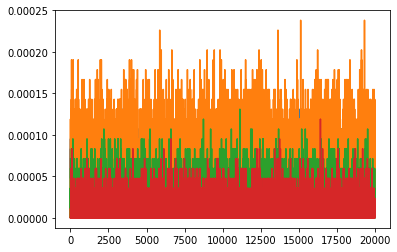

In [138]:
import matplotlib.pyplot as plt
nCases = liabParams55cov["nCases"]
nCtrls = liabParams55cov["nCtrls"]
print("liabData55cov['altCounts'] / (nCases.sum() + nCtrls)", liabData55cov["altCounts"] / (nCases.sum() + nCtrls))
plt.plot(liabData55cov["altCounts"] / (nCases.sum() + nCtrls))

In [38]:
liabData55cov["altCounts"][liabData55cov["affectedGenes"][0]]

tensor([[4., 7., 0., 0.],
        [4., 4., 0., 0.],
        [3., 3., 1., 3.],
        ...,
        [2., 3., 0., 3.],
        [1., 6., 2., 1.],
        [3., 6., 0., 0.]], dtype=torch.float64)

In [124]:
(liabData55cov["afs"][liabData55cov["affectedGenes"][2]]).mean(0)

tensor([5.5561e-05, 9.1572e-05, 3.6856e-05, 1.3917e-05], dtype=torch.float64)

In [134]:
(liabData55cov["afs"][liabData55cov["unaffectedGenes"]]).mean(0).sum()

tensor(9.9994e-05, dtype=torch.float64)

In [48]:
liabData55cov["afs"][liabData55cov["affectedGenes"][0]].mean(0) 

tensor([5.5311e-05, 9.1487e-05, 1.7899e-05, 2.4397e-05], dtype=torch.float64)

In [17]:
liabParams55cov["afMean"]

tensor(1.0000e-04)

In [18]:
liabData55cov["afs"][liabData55cov["affectedGenes"][0]].mean(0)

tensor([5.7334e-05, 5.5250e-05, 1.7842e-05, 1.4733e-05], dtype=torch.float64)

In [19]:
liabParams55cov["afMean"]

tensor(1.0000e-04)